# Check on the files exported by Equivital Qiosk
for RITMO

TODO

Plot and review measurements from equivital sensors as output by the Equivital Manager app.
(Every program produces different formated files and it's a pain.)

In [60]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import heartpy as hp

from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

## Definitions for data extraction

In [61]:
%load_ext autoreload
%autoreload 1
%aimport qex

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
%reload_ext autoreload

# Scan for DATA files
Check the usual spot that QIOSK deposits files for data files detailing recordings

In [62]:
# location of the files when exported by QIOSK
path = "C:\\Users\\Public\\Documents\\Equivital\\Equivital Manager Wizard\\"#Extracted SEM Data\\" #"../Equivital/Equivital Manager Wizard/Extracted SEM Data/"
#os.listdir(path)

df_datafiles = qex.qiosk_recordings(path,'Present')
df_datafiles

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
0,DATA,Pilot_1,3420755,230203,101,DATA-Pilot_1-3420755-23020300_0.CSV,csv,109,2020-02-02 02:02:00+00:00,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DATA,Pilot_1,3420755,230203,1,DATA-Pilot_1-3420755-23020301.CSV,csv,109,2020-02-02 02:02:00+00:00,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DATA,Pilot_2,3420456,230130,0,DATA-Pilot_2-3420456-23013000.CSV,csv,109,2020-02-02 02:02:00+00:00,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DATA,Bluetooth_Tester_1,3420415,230203,0,DATA-Bluetooth_Tester_1-3420415-23020300.CSV,csv,9077,2023-02-03 11:06:28+00:00,2023-02-03 11:35:43+00:00,...,[Pilot_1],3420415.0,Pilot_1,NaN,0.0,100.0,1.0,1.0,Stationary,Side
4,DATA,Pilot_1,3420755,230203,0,DATA-Pilot_1-3420755-23020300.CSV,csv,9455,2023-02-03 11:06:28+00:00,2023-02-03 11:35:43+00:00,...,[Pilot_1],3420755.0,Pilot_1,NaN,66.0,98.0,0.0,0.0,Stationary,Upright
5,DATA,Pilot_2,3420456,230203,0,DATA-Pilot_2-3420456-23020300.CSV,csv,8532,2023-02-03 11:40:06+00:00,2023-02-03 12:06:36+00:00,...,[Pilot_2],3420456.0,Pilot_2,NaN,0.0,99.0,0.0,0.0,Stationary,Upright
6,DATA,Pilot_1,3420755,230203,102,DATA-Pilot_1-3420755-23020300_1.CSV,csv,8613,2023-02-03 11:40:31+00:00,2023-02-03 12:06:46+00:00,...,"[Bluetooth_Tester_1, Pilot_2]",3420755.0,Pilot_2,NaN,0.0,100.0,1.0,1.0,Stationary,Side
7,DATA,Bluetooth_Tester_1,3420415,230203,101,DATA-Bluetooth_Tester_1-3420415-23020300_0.CSV,csv,8573,2023-02-03 11:40:39+00:00,2023-02-03 12:06:54+00:00,...,"[Bluetooth_Tester_1, Pilot_2]",3420415.0,Pilot_2,NaN,0.0,100.0,1.0,1.0,Stationary,Side


In [46]:
# location of the files when in one of the local project files
projectName = 'MusiciansPilot' # this needs to match the project folder name
path = "C:\\Users\\fourMs lab\\Documents\\Equivital\\ProjectData\\"+projectName+"\\"#Extracted SEM Data\\" #"../Equivital/Equivital Manager Wizard/Extracted SEM Data/"
#os.listdir(path)

df_datafiles = qex.qiosk_recordings(path,projectName)
df_datafiles

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
0,DATA,Pilot_1,3420755,230127,0,DATA-Pilot_1-3420755-23012700.CSV,csv,25758,2023-01-27 08:56:16+00:00,2023-01-27 10:16:01+00:00,...,[Pilot_1],3420755.0,Pilot_1,NaN,113,98.0,0.0,0.0,Stationary,Upright
1,DATA,Pilot_2,3420456,230127,0,DATA-Pilot_2-3420456-23012700.CSV,csv,23211,2023-01-27 09:04:17+00:00,2023-01-27 10:16:02+00:00,...,[Pilot_2],3420456.0,Pilot_2,NaN,109,95.0,0.0,0.0,Stationary,Upright
2,DATA,Bluetooth_Tester_3,3420426,230127,1,DATA-Bluetooth_Tester_3-3420426-23012701.CSV,csv,25407,2023-01-27 09:04:22+00:00,2023-01-27 10:16:07+00:00,...,[Bluetooth_Tester_3],3420426.0,Bluetooth_Tester_3,NaN,0,100.0,1.0,1.0,Stationary,Side
3,DATA,Pilot_3,3420427,230127,0,DATA-Pilot_3-3420427-23012700.CSV,csv,22446,2023-01-27 09:05:35+00:00,2023-01-27 10:16:05+00:00,...,[Pilot_3],3420427.0,Pilot_3,NaN,88,98.0,0.0,0.0,Stationary,Upright
4,DATA,Pilot_4,5022138,230127,0,DATA-Pilot_4-5022138-23012700.CSV,csv,23008,2023-01-27 09:10:11+00:00,2023-01-27 10:22:11+00:00,...,[Pilot_4],5022138.0,Pilot_4,NaN,84,97.0,0.0,0.0,Stationary,Upright
5,DATA,Pilot_5,5022126,230127,0,DATA-Pilot_5-5022126-23012700.CSV,csv,21942,2023-01-27 09:11:46+00:00,2023-01-27 10:20:16+00:00,...,[Pilot_5],5022126.0,Pilot_5,NaN,84,98.0,0.0,0.0,Stationary,Upright
6,DATA,Bluetooth_Tester_1,3420415,230127,1,DATA-Bluetooth_Tester_1-3420415-23012701.CSV,csv,22177,2023-01-27 09:13:37+00:00,2023-01-27 10:16:07+00:00,...,[Bluetooth_Tester_1],3420415.0,Bluetooth_Tester_1,NaN,0,100.0,1.0,1.0,Stationary,Side
7,DATA,Pilot_6,5022139,230127,0,DATA-Pilot_6-5022139-23012700.CSV,csv,17724,2023-01-27 09:20:35+00:00,2023-01-27 10:16:05+00:00,...,[Pilot_6],5022139.0,Pilot_6,NaN,56,99.0,0.0,0.0,Stationary,Upright
8,DATA,Pilot_7,5022050,230127,0,DATA-Pilot_7-5022050-23012700.CSV,csv,17619,2023-01-27 09:20:46+00:00,2023-01-27 10:16:01+00:00,...,[Pilot_7],5022050.0,Pilot_7,NaN,74,98.0,0.0,0.0,Stationary,Upright
9,DATA,Pilot_8,5022281,230127,0,DATA-Pilot_8-5022281-23012700.CSV,csv,14933,2023-01-27 09:29:12+00:00,2023-01-27 10:15:42+00:00,...,[Pilot_8],5022281.0,Pilot_8,NaN,85,97.0,0.0,0.0,Stationary,Upright


In [63]:
# key categories to structure of Qiosk output DATA files
print('Number of DATA files: '+ str(len(df_datafiles)))
print(df_datafiles['ID'].unique())
print(df_datafiles['Date'].unique())

Number of DATA files: 8
[3420755 3420456 3420415]
[230203 230130]


# Review recordings from a specific device and recording time
First preview files from a specific device (or other feild), then find the other signal files that match that Data files

In [64]:
# DATA files from one device, by the more reliable device ID numbr
devN = 3420415
#s_files=df_datafiles.loc[df_datafiles['ID'] == devN,:] 
s_files=df_datafiles.loc[df_datafiles['Date'] == 230203,:]

# t = pd.to_datetime('2023-01-27 10:30:00.00+0000')# V['DateTime'].iloc[int(len(V)/2)]
# s_files=s_files.loc[s_files['RecStart']< t,:] 
s_files

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
0,DATA,Pilot_1,3420755,230203,101,DATA-Pilot_1-3420755-23020300_0.CSV,csv,109,2020-02-02 02:02:00+00:00,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DATA,Pilot_1,3420755,230203,1,DATA-Pilot_1-3420755-23020301.CSV,csv,109,2020-02-02 02:02:00+00:00,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DATA,Bluetooth_Tester_1,3420415,230203,0,DATA-Bluetooth_Tester_1-3420415-23020300.CSV,csv,9077,2023-02-03 11:06:28+00:00,2023-02-03 11:35:43+00:00,...,[Pilot_1],3420415.0,Pilot_1,NaN,0.0,100.0,1.0,1.0,Stationary,Side
4,DATA,Pilot_1,3420755,230203,0,DATA-Pilot_1-3420755-23020300.CSV,csv,9455,2023-02-03 11:06:28+00:00,2023-02-03 11:35:43+00:00,...,[Pilot_1],3420755.0,Pilot_1,NaN,66.0,98.0,0.0,0.0,Stationary,Upright
5,DATA,Pilot_2,3420456,230203,0,DATA-Pilot_2-3420456-23020300.CSV,csv,8532,2023-02-03 11:40:06+00:00,2023-02-03 12:06:36+00:00,...,[Pilot_2],3420456.0,Pilot_2,NaN,0.0,99.0,0.0,0.0,Stationary,Upright
6,DATA,Pilot_1,3420755,230203,102,DATA-Pilot_1-3420755-23020300_1.CSV,csv,8613,2023-02-03 11:40:31+00:00,2023-02-03 12:06:46+00:00,...,"[Bluetooth_Tester_1, Pilot_2]",3420755.0,Pilot_2,NaN,0.0,100.0,1.0,1.0,Stationary,Side
7,DATA,Bluetooth_Tester_1,3420415,230203,101,DATA-Bluetooth_Tester_1-3420415-23020300_0.CSV,csv,8573,2023-02-03 11:40:39+00:00,2023-02-03 12:06:54+00:00,...,"[Bluetooth_Tester_1, Pilot_2]",3420415.0,Pilot_2,NaN,0.0,100.0,1.0,1.0,Stationary,Side


In [65]:
fileN = 5
eq_file_loc = s_files.loc[fileN,'FullLoc']
print(s_files.loc[fileN,:])

Signal                                                            DATA
DevName                                                        Pilot_2
ID                                                             3420456
Date                                                            230203
Session                                                              0
FileName                             DATA-Pilot_2-3420456-23020300.CSV
FileType                                                           csv
FileSize                                                          8532
RecStart                                     2023-02-03 11:40:06+00:00
RecEnd                                       2023-02-03 12:06:36+00:00
Duration                                                        1590.0
BatteryStart                                                    4076.0
BatteryEnd                                                      4065.0
BatteryChange(mV)                                                -11.0
FullLo

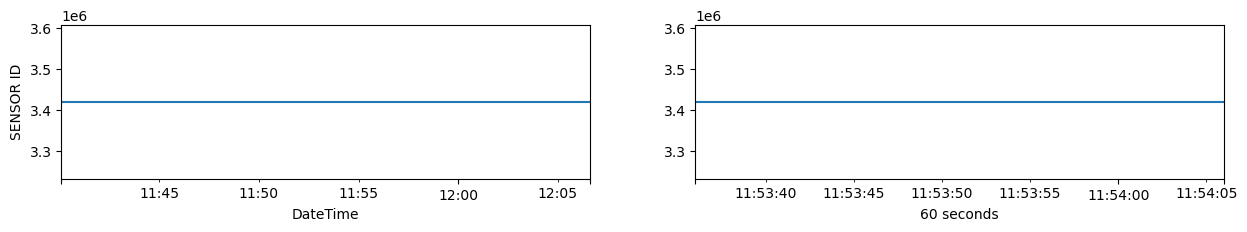

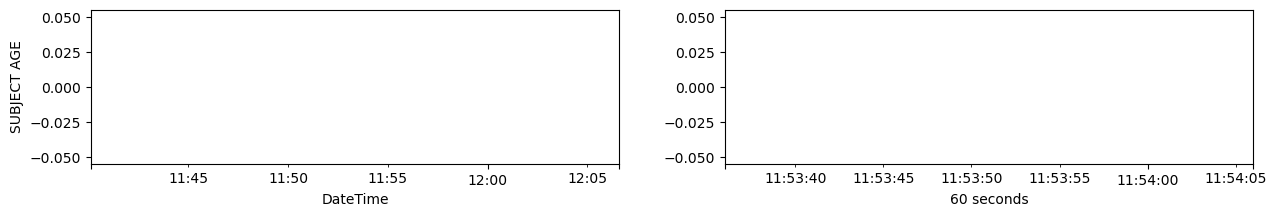

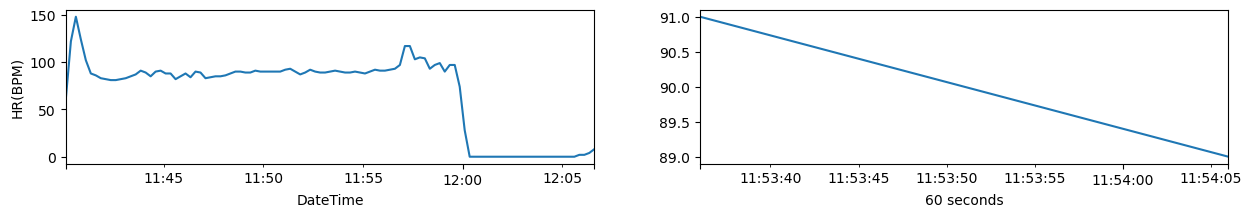

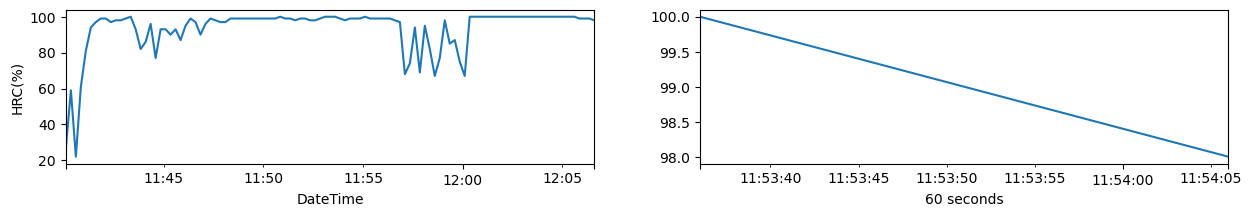

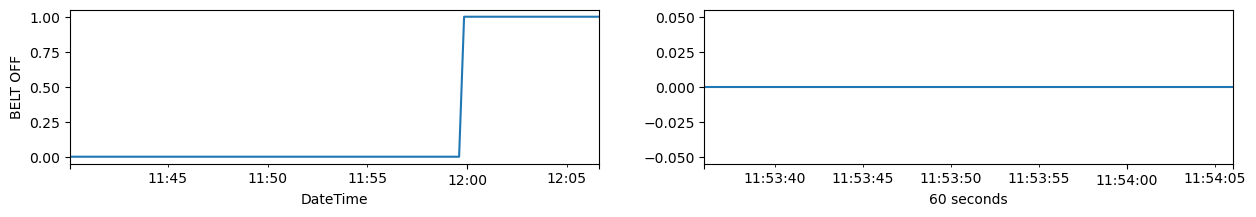

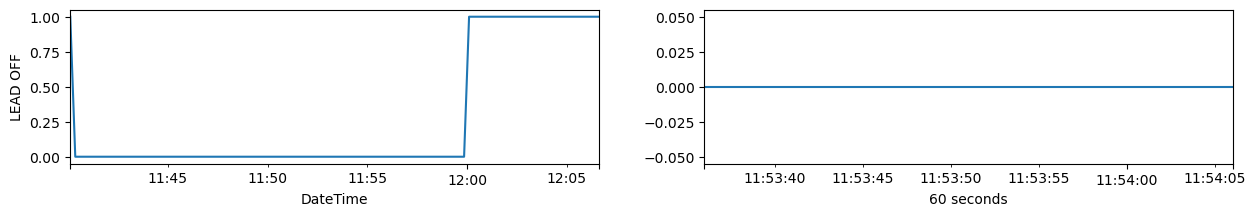

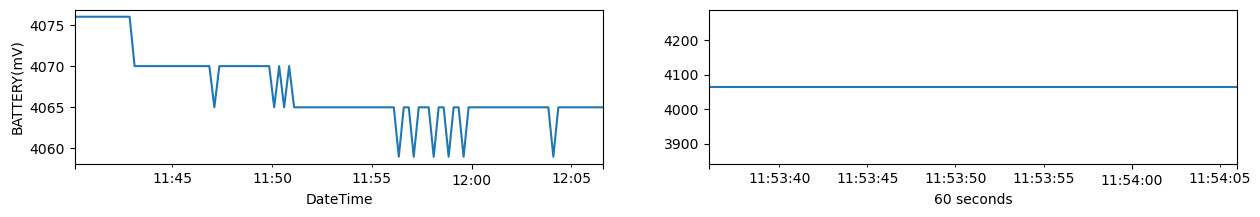

,DateTime,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION,BATTERY(mV)
0,2023-02-03 11:40:06+00:00,3420456,Pilot_2,NaN,62,27,0,1,MovingSlowly,Prone,4076
1,2023-02-03 11:40:21+00:00,3420456,Pilot_2,NaN,122,59,0,0,MovingSlowly,Upright,4076
2,2023-02-03 11:40:36+00:00,3420456,Pilot_2,NaN,148,22,0,0,MovingSlowly,Upright,4076
3,2023-02-03 11:40:51+00:00,3420456,Pilot_2,NaN,124,61,0,0,MovingSlowly,Upright,4076
4,2023-02-03 11:41:06+00:00,3420456,Pilot_2,NaN,102,81,0,0,Stationary,Upright,4076


In [66]:
# Plot a quick view of the DATA file numeric fields
V = pd.read_csv(eq_file_loc,skipinitialspace=True)
qex.test_plot_signals(V)
V.iloc[:5]

Now grab all the files from that recording and presente a test plot of each, full and middle minute


C:\Users\Public\Documents\Equivital\Equivital Manager Wizard\Extracted SEM Data\Pilot_2\DATA-Pilot_2-3420456-23020300.CSV


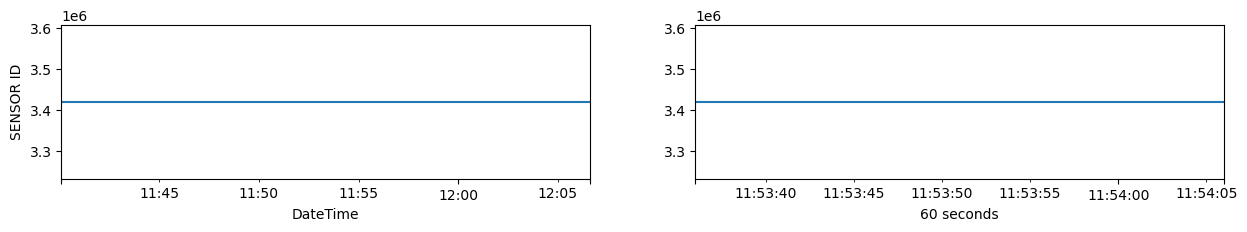

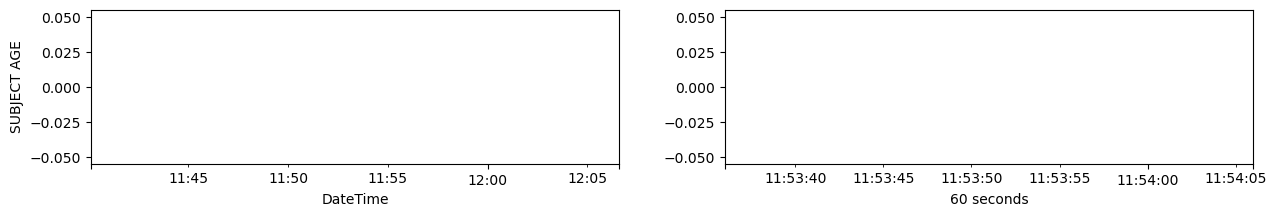

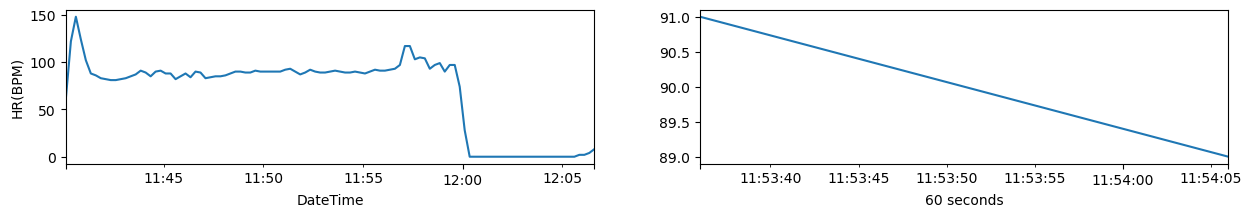

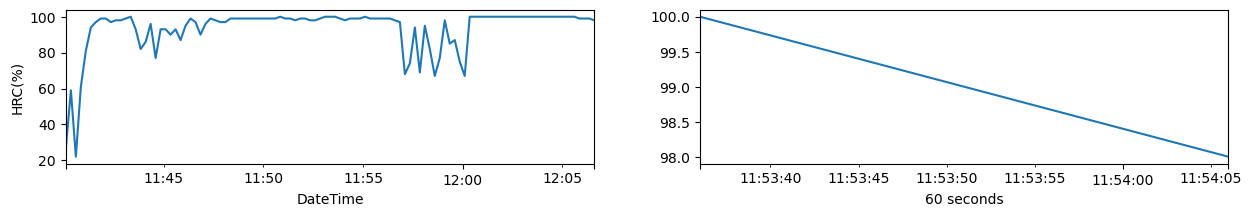

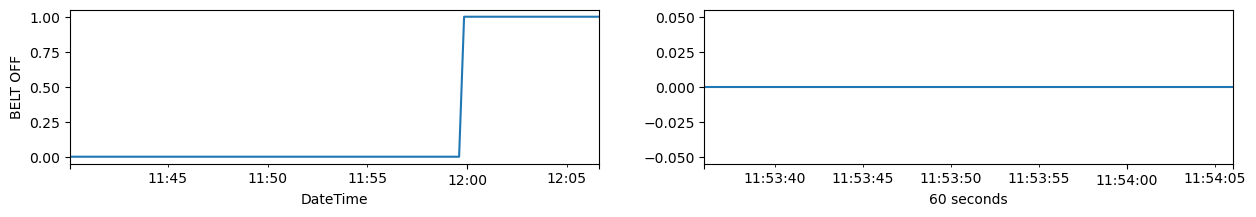

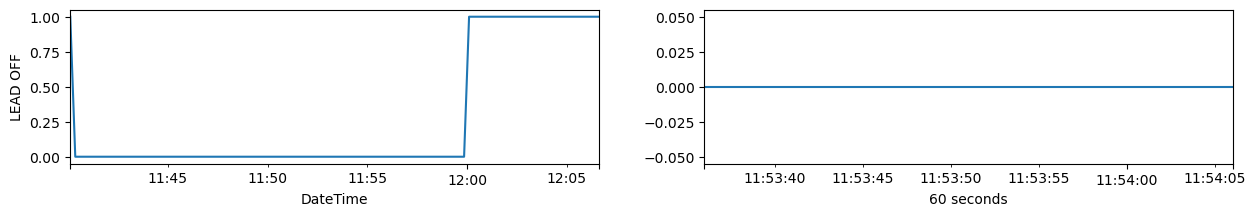

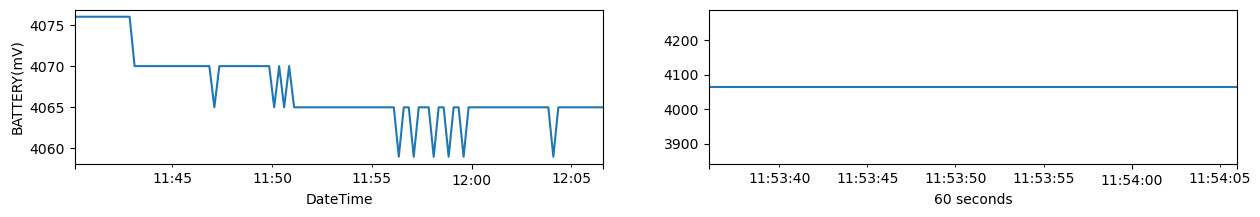

C:\Users\Public\Documents\Equivital\Equivital Manager Wizard\Extracted SEM Data\Pilot_2\ECG-Pilot_2-3420456-23020300.csv


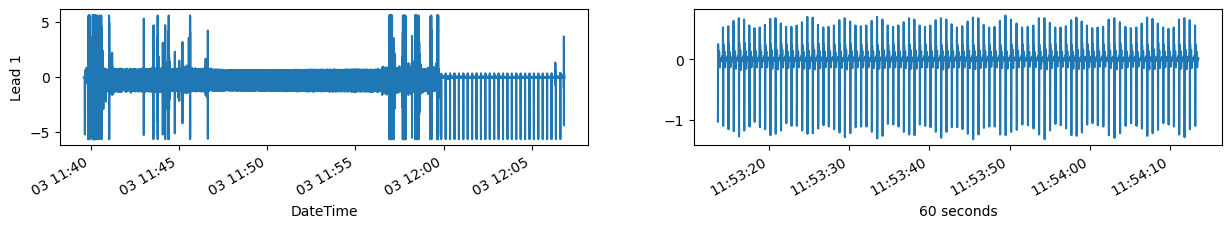

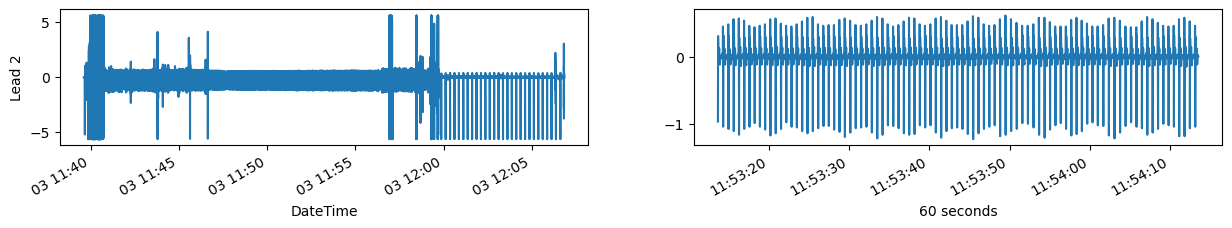

C:\Users\Public\Documents\Equivital\Equivital Manager Wizard\Extracted SEM Data\Pilot_2\RESPACC-Pilot_2-3420456-23020300.CSV


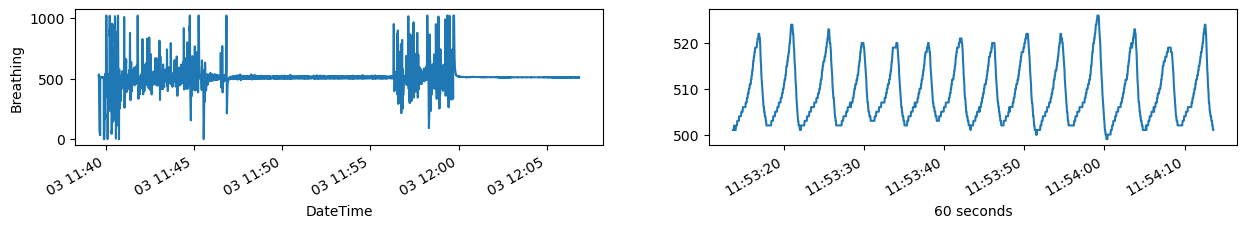

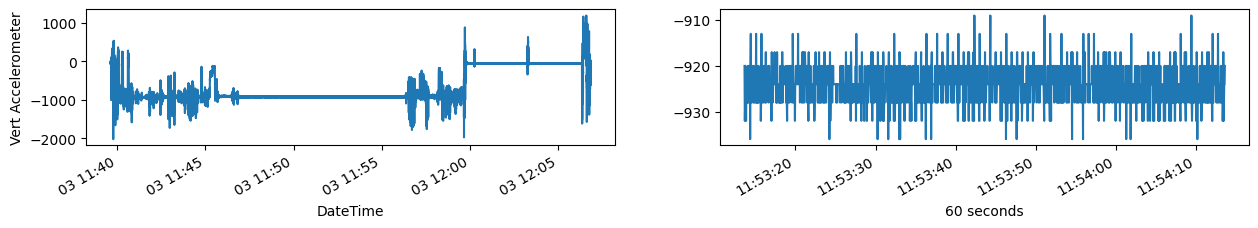

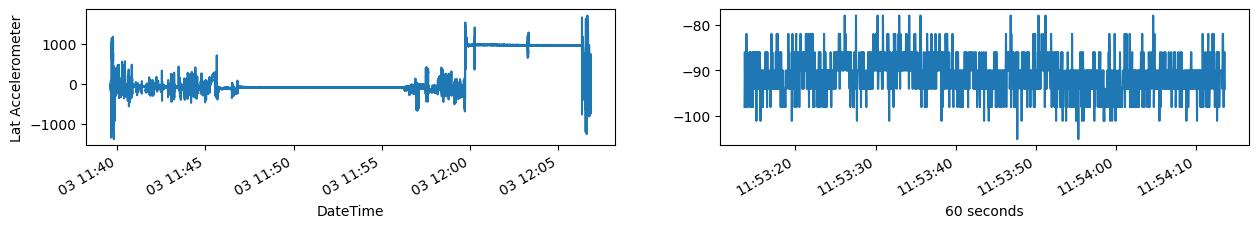

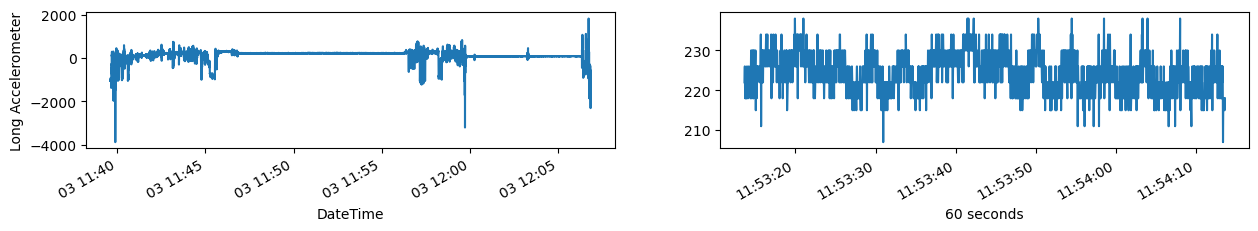

C:\Users\Public\Documents\Equivital\Equivital Manager Wizard\Extracted SEM Data\Pilot_2\RR-Pilot_2-3420456-23020300.CSV


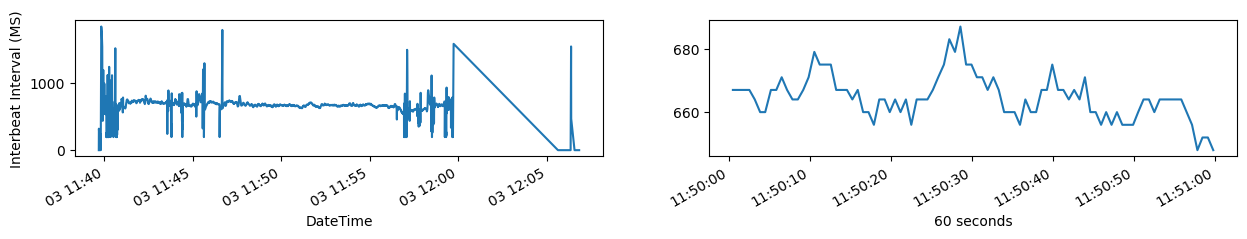

C:\Users\Public\Documents\Equivital\Equivital Manager Wizard\Raw SEM Data\Pilot_2\23020300.SEM
Not enough data


In [67]:
matched = qex.matched_files(s_files.loc[fileN,'FullLoc'],path) # outputs locations of csv 
for eq_file_loc in matched:
    print(eq_file_loc)
    V = pd.read_csv(eq_file_loc,skipinitialspace=True)
    qex.test_plot_signals(V)

# Plot all signals recorded at specific time

In [68]:
#fileN = 
eq_file_loc = df_datafiles.loc[fileN,'FullLoc']
print(df_datafiles.loc[fileN,:])

Signal                                                            DATA
DevName                                                        Pilot_2
ID                                                             3420456
Date                                                            230203
Session                                                              0
FileName                             DATA-Pilot_2-3420456-23020300.CSV
FileType                                                           csv
FileSize                                                          8532
RecStart                                     2023-02-03 11:40:06+00:00
RecEnd                                       2023-02-03 12:06:36+00:00
Duration                                                        1590.0
BatteryStart                                                    4076.0
BatteryEnd                                                      4065.0
BatteryChange(mV)                                                -11.0
FullLo

In [71]:
# the times at which you want to check the recording
# note: make sure you set the times to within the recording interval for that file!!
t1 = pd.to_datetime('2023-02-03 11:57:06+00:00')# V['DateTime'].iloc[int(len(V)/2)]
t2 = t1+pd.to_timedelta(300,'s')
[t1,t2]

[Timestamp('2023-02-03 11:57:06+0000', tz='UTC'),
 Timestamp('2023-02-03 12:02:06+0000', tz='UTC')]

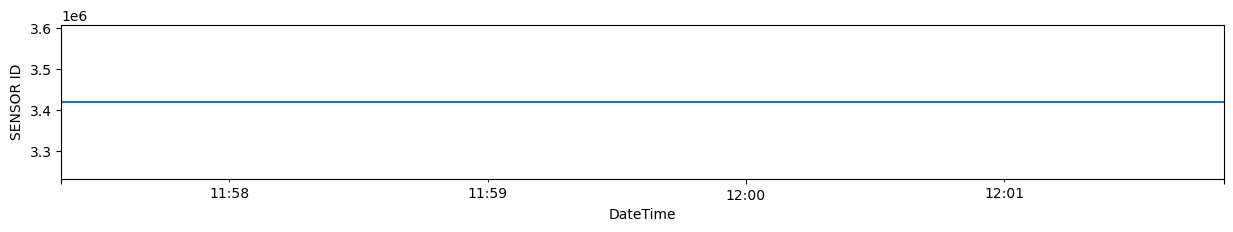

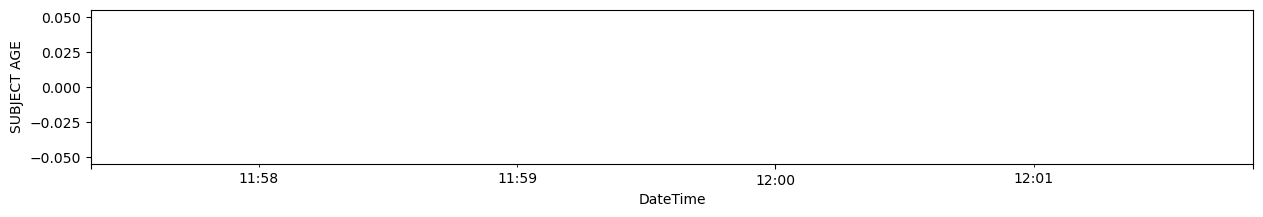

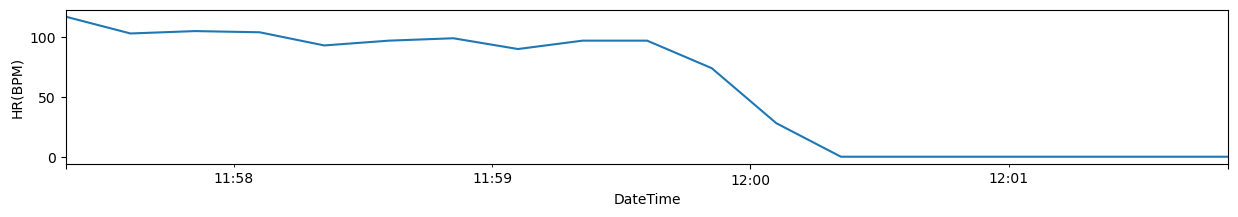

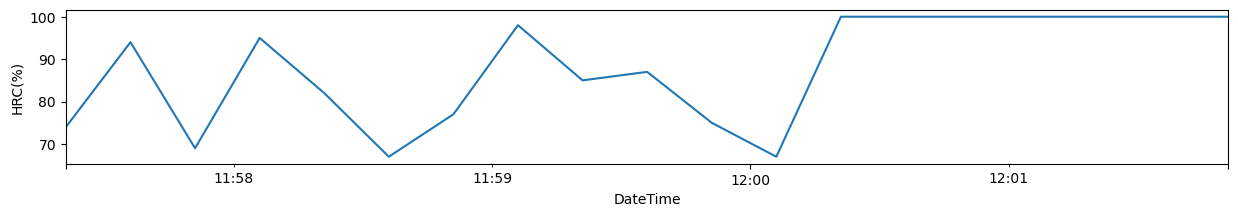

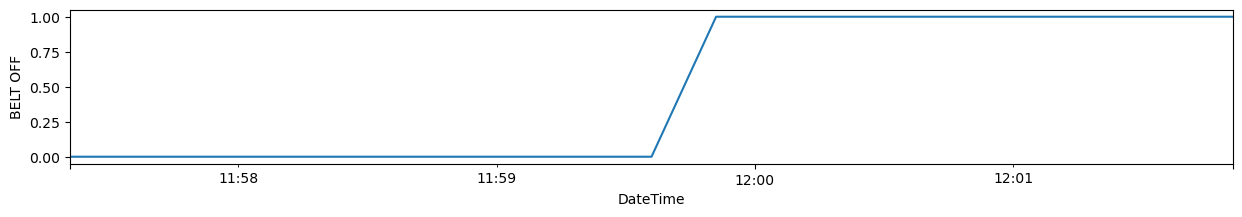

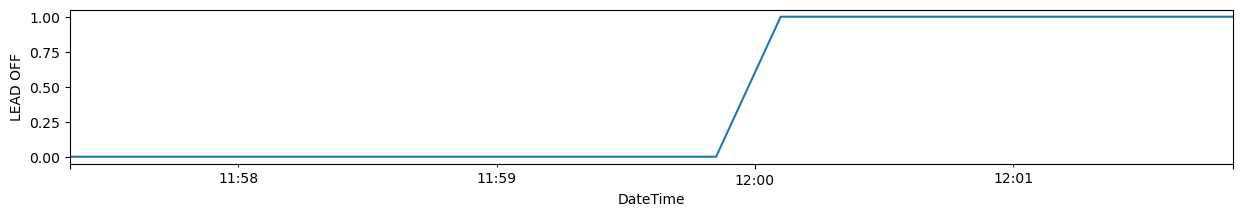

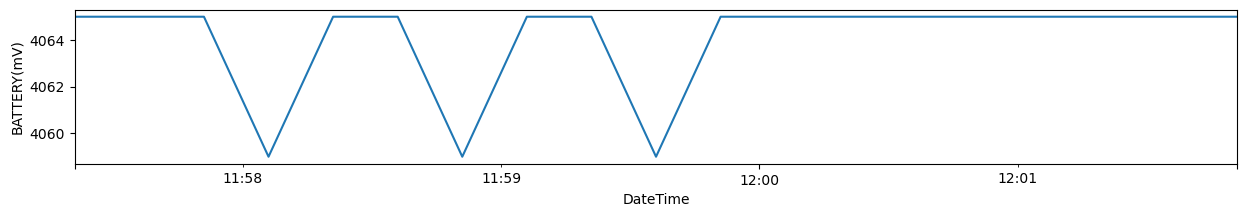

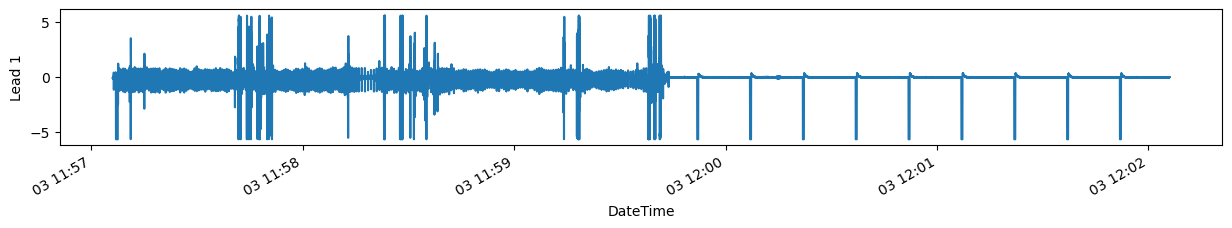

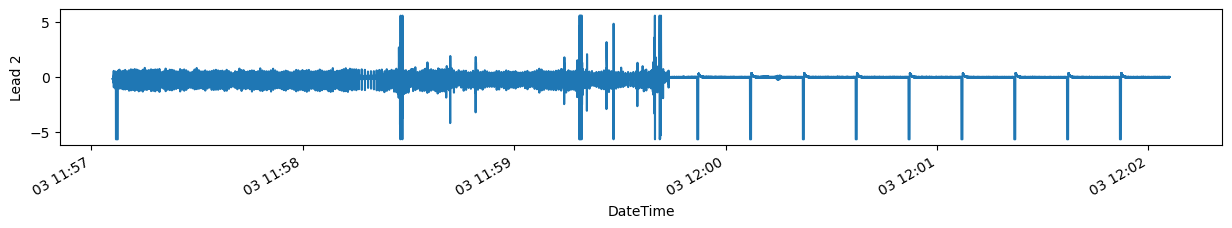

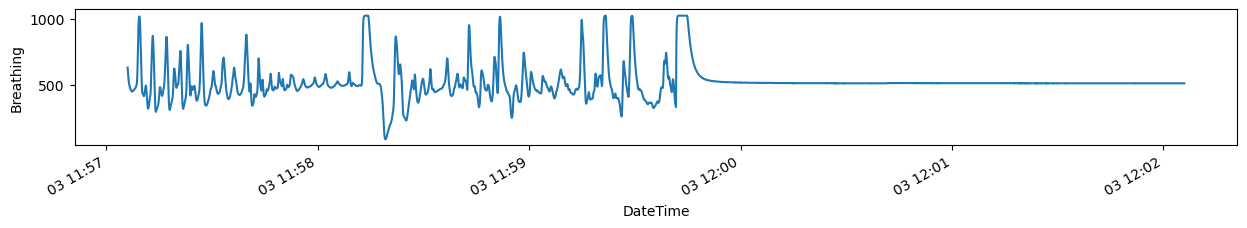

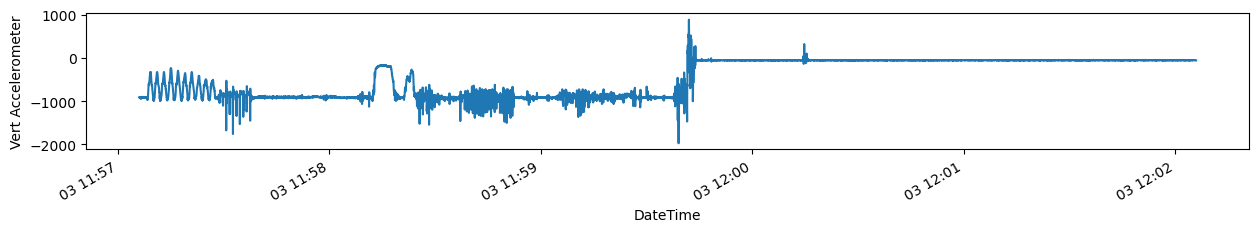

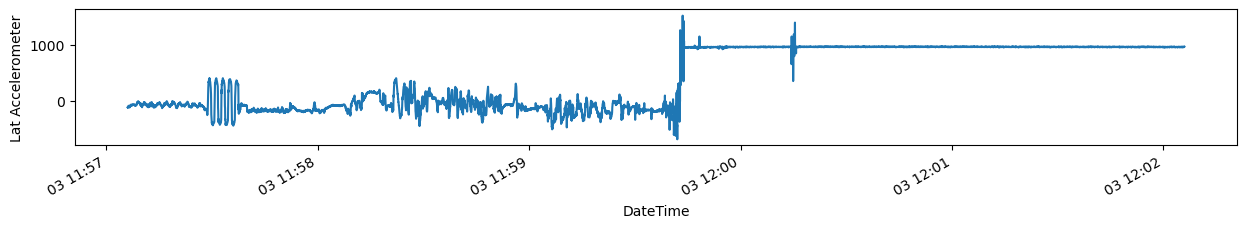

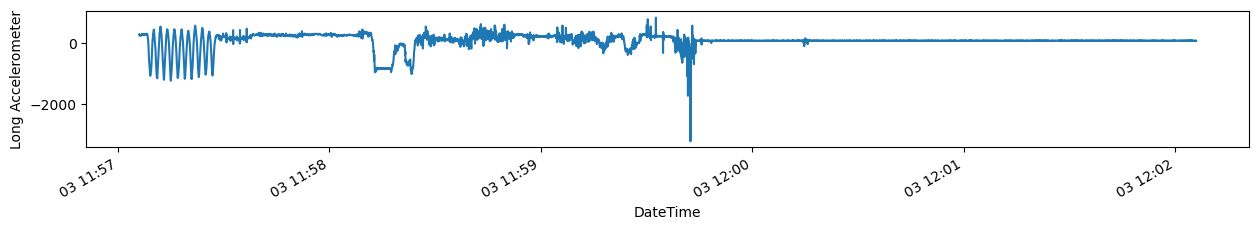

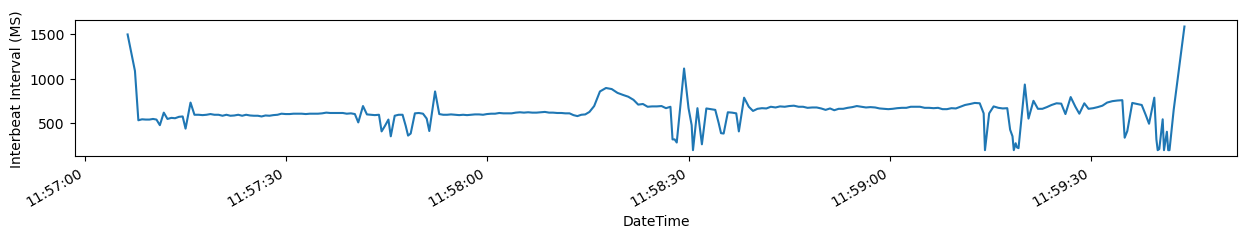

No data


In [72]:
for eq_file_loc in matched:
    V = pd.read_csv(eq_file_loc,skipinitialspace=True)
#     print(V.iloc[:2,:])
    qex.test_plot_signals_interval(V,t1,t2)

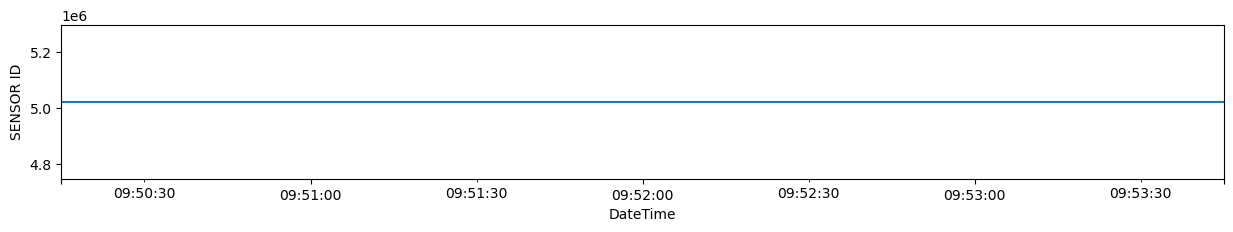

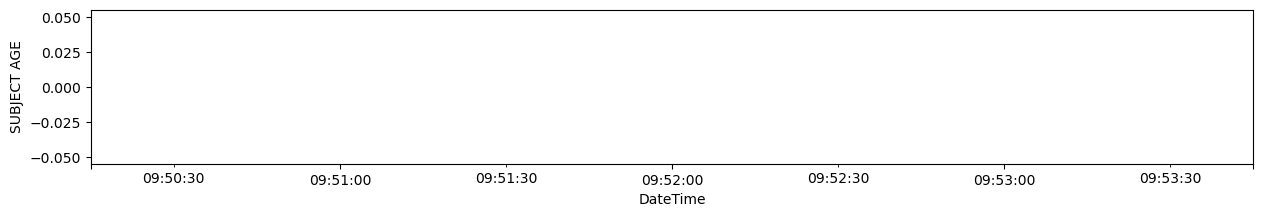

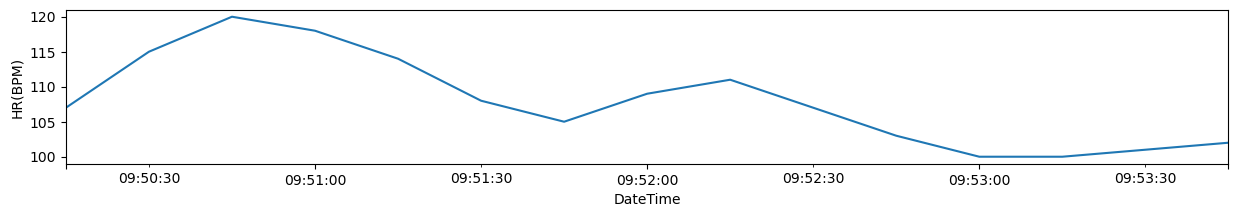

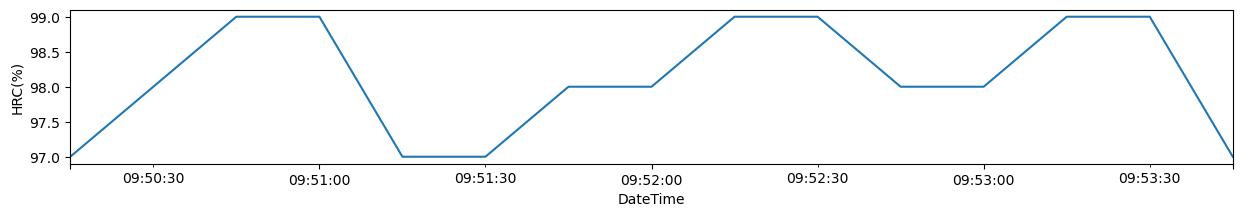

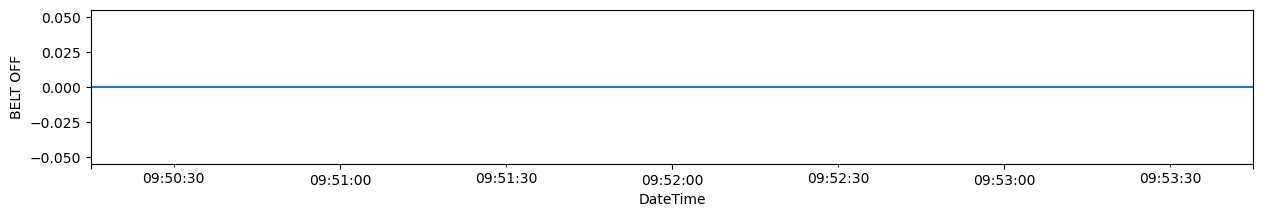

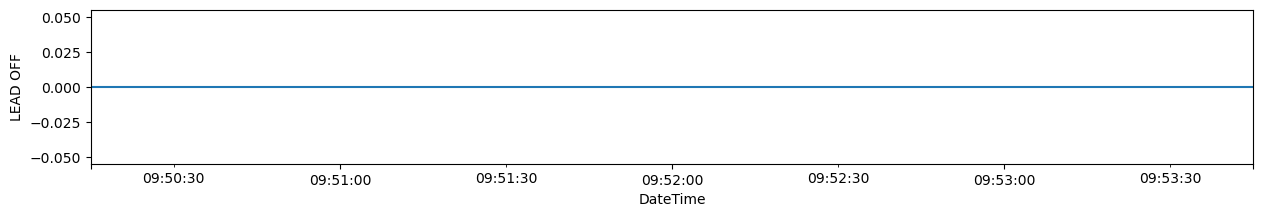

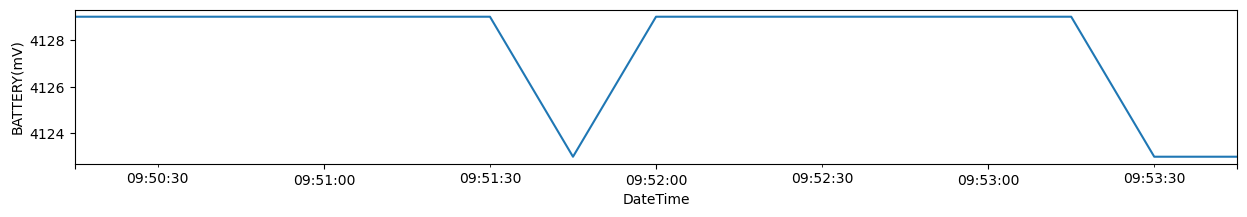

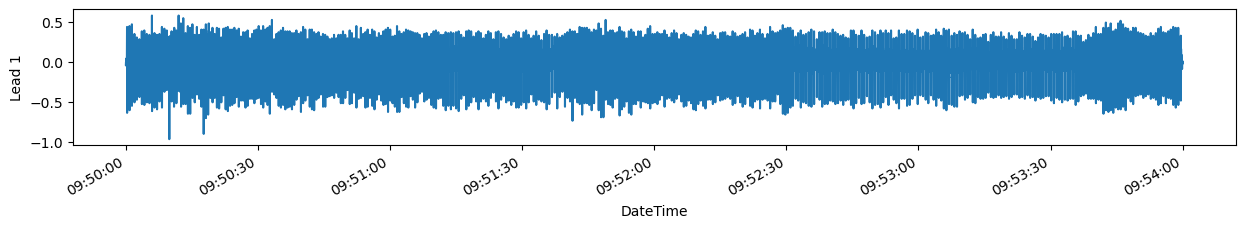

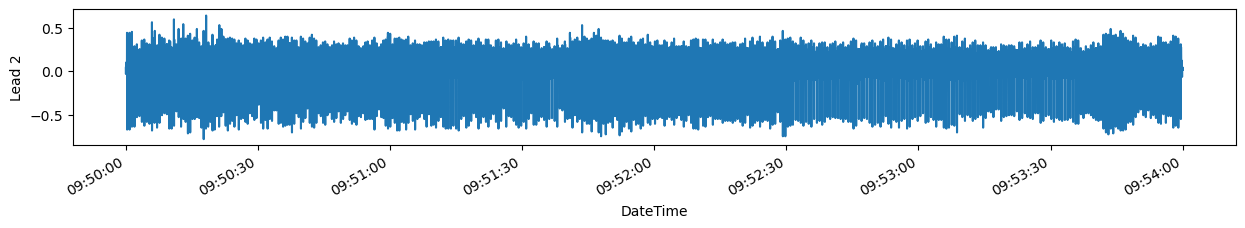

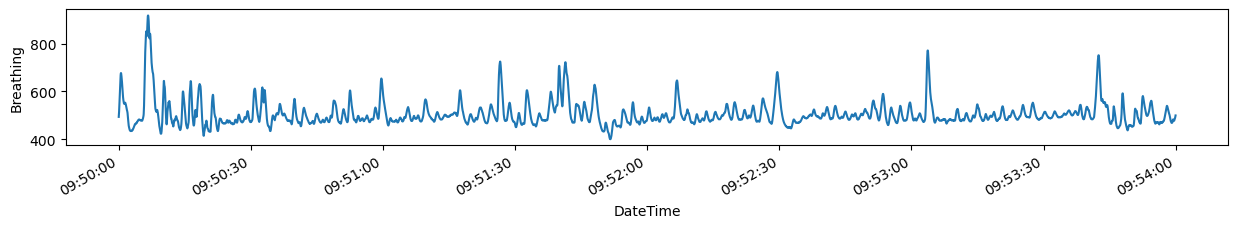

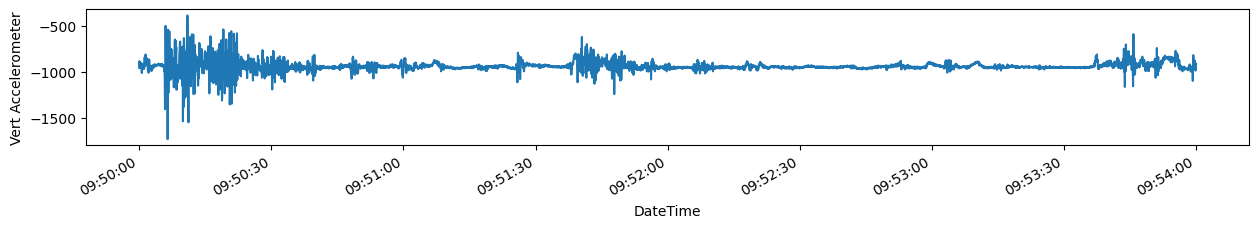

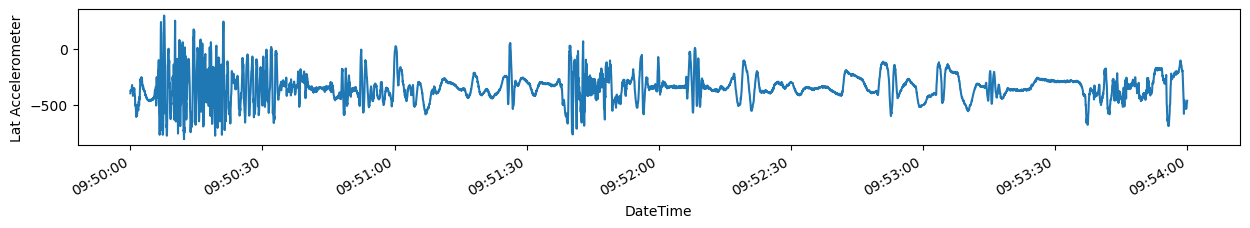

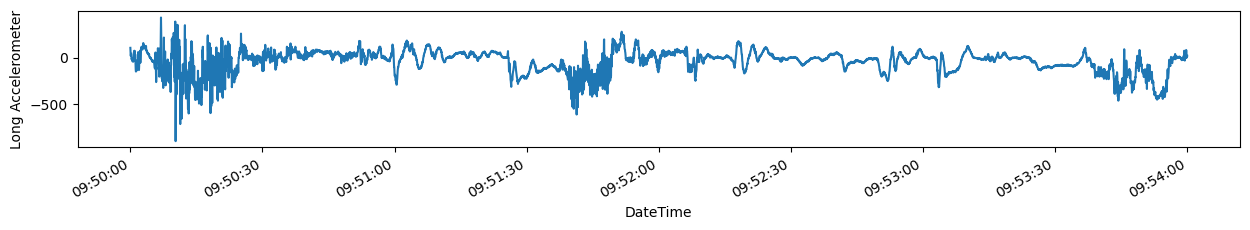

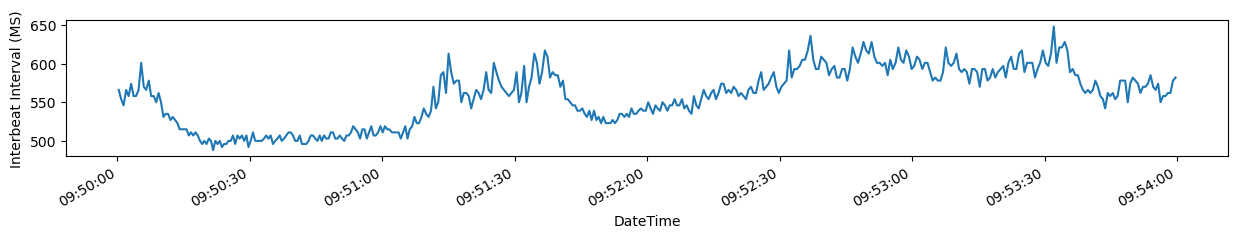

No data


In [59]:
# to save exported plots
plotname = 'ViolinPlayingPilot'
for eq_file_loc in matched:
    V = pd.read_csv(eq_file_loc,skipinitialspace=True)
#     print(V.iloc[:2,:])
    qex.test_plot_signals_interval_save(V,t1,t2,plotname)

In [45]:
eq_file_loc

'C:\\Users\\fourMs lab\\Documents\\Equivital\\ProjectData\\SoloRecordings\\SEM\\Pilot_1\\23020100_1.SEM'